In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
!wget https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
!tar -xzf 102flowers.tgz -C ./
!wget https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat
!wget https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat

--2024-04-22 21:44:28--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  20.0MB/s    in 16s     

2024-04-22 21:44:46 (20.0 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2024-04-22 21:44:50--  https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2024-04-22 21

In [ ]:
labels = scipy.io.loadmat('imagelabels.mat')
print(labels)
print(labels['labels'].shape)
labels = labels['labels'][0]

imgs = []
for i in range(1, labels.shape[0]+1):
  number_string = "{:05d}".format(i)
  image = Image.open(f"jpg/image_{number_string}.jpg")
  image = image.resize((256,256))
  image_array = np.array(image)
  imgs.append(image_array)

imgs = np.stack(imgs, axis=0)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009', '__version__': '1.0', '__globals__': [], 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}
(1, 8189)


In [ ]:
random_labels = np.random.choice(labels.max(), 10, replace=False)
chosen_labels_mask = np.isin(labels, random_labels)
labels = labels[chosen_labels_mask]
_, labels_inverse = np.unique(labels, return_inverse=True)
labels = np.arange(10)[labels_inverse]
imgs = imgs[chosen_labels_mask]

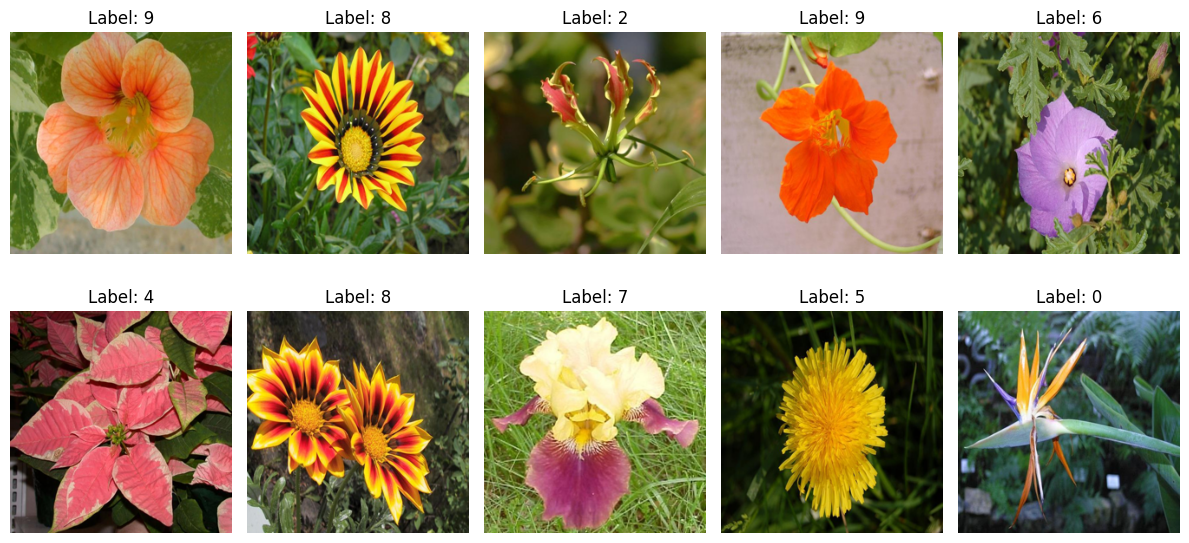

In [ ]:
random_indices = np.random.choice(len(imgs), 10, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
imgs = imgs.astype(np.float32) / 255

In [ ]:
perm = np.random.permutation(labels.shape[0])
imgs = imgs[perm,:,:,:]
labels = labels[perm]

# calculate split sizes
split0 = int(labels.shape[0]*0.6)
split1 = int(labels.shape[0]*0.8)

# split datasets
xs_train = imgs[:split0,:,:,:]
xs_val = imgs[split0:split1,:,:,:]
xs_test = imgs[split1:,:,:,:]
ys_train = labels[:split0]
ys_val = labels[split0:split1]
ys_test = labels[split1:]

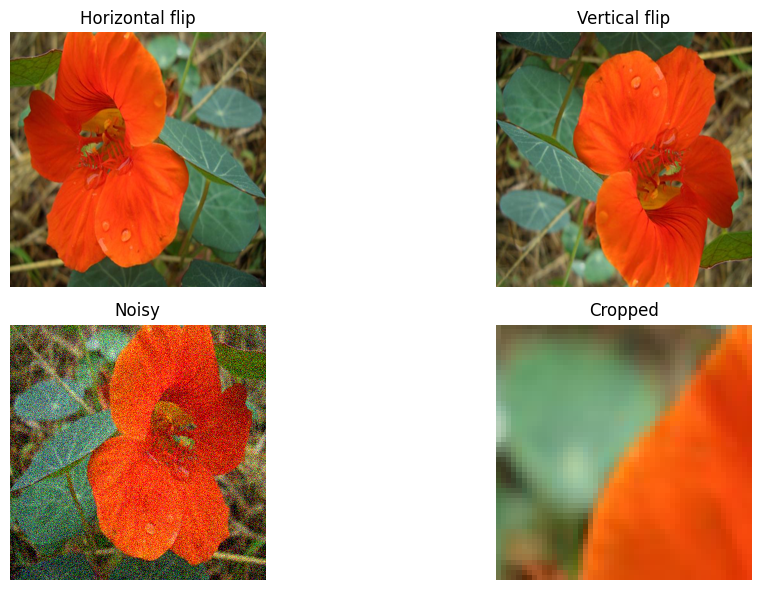

In [ ]:
vis_img = torch.tensor(xs_train[0])

horizontally_flipped = vis_img.flip(1)

vertically_flipped = vis_img.flip(0)

noised = vis_img + torch.normal(0.0, 0.1, vis_img.shape)

crop_size_y, crop_size_x = 50, 50
start_y_coord = torch.randint(0, vis_img.shape[0] - 50, (1,))
start_x_coord = torch.randint(0, vis_img.shape[1] - 50, (1,))
cropped_img = vis_img[start_y_coord:start_y_coord + crop_size_y, start_x_coord:start_x_coord + crop_size_x,:]

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(horizontally_flipped)
plt.title("Horizontal flip")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(vertically_flipped)
plt.title("Vertical flip")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(noised)
plt.title("Noisy")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cropped_img)
plt.title("Cropped")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class FlowersDataset(Dataset):
    def __init__(self, images, labels, transform=None, device='cpu'):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], device=self.device)
        image = torch.permute(image,(2,0,1))
        label = torch.tensor(self.labels[idx], device=self.device)

        if self.transform:
            image = self.transform(image)

        return image, label

mobilnet_mean = [0.485, 0.456, 0.406]
mobilnet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
device = 'cuda:0'
train_dataset = FlowersDataset(xs_train, ys_train, transform=train_transform, device=device)
val_dataset = FlowersDataset(xs_val, ys_val, transform=eval_transform, device=device)
test_dataset = FlowersDataset(xs_test, ys_test, transform=eval_transform, device=device)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

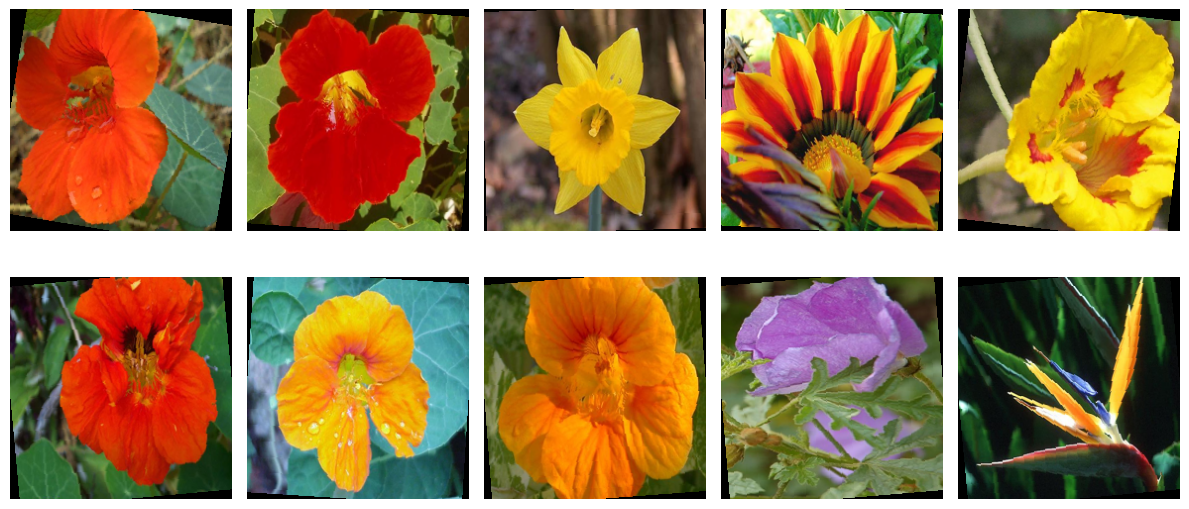

In [ ]:
vis_imgs = [train_dataset[i][0].cpu() for i in range(10)]

plt.figure(figsize=(12, 6))
for i, img in enumerate(vis_imgs):
    plt.subplot(2, 5, i + 1)
    img = img.permute(1,2,0) * torch.tensor(mobilnet_std) + torch.tensor(mobilnet_mean)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 84.3MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
class ImageClassificationNet(torch.nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.mobilnet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        self.mobilnet.features = torch.nn.Sequential(*list(self.mobilnet.features.children())[:4])
        for param in self.mobilnet.parameters():
          param.requires_grad = False

        self.feature_exctractor = torch.nn.Sequential(
            torch.nn.Conv2d(24,32,(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(32,64,(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(64,64,(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((7,7)),
        )

        self.classifier = torch.nn.Linear(64, n_class)

    def forward(self, x):
      out = self.mobilnet.features(x)
      out = self.feature_exctractor(out) # (batch_size, 64, 1, 1)
      out = torch.squeeze(out, dim=(2,3))
      out = self.classifier(out)
      return out

In [ ]:
class AlternativeNet(torch.nn.Module):
    def __init__(self):
        self.net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        self.remove_handle = self.net._modules['features'][4].register_forward_hook(self.forward_hook)
        self.forward_output = None

    def forward_hook(self, module, input, output):
        # save any modules output in an attribute and later use it in backprop.
        self.forward_output = output

    def forward(self, x):
      _ = self.net(x)
      out = self.forward_output

In [ ]:
def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=10, delta=0.01, patience=10):
  train_losses = []
  val_losses = []

  best_loss = np.inf
  no_improvement_count = 0

  for epoch in range(n_epochs):
    model.train()
    train_epoch_losses = []

    for x, y in train_dataloader:
      optimizer.zero_grad()
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      train_epoch_losses.append(loss)
      loss.backward()
      optimizer.step()

    train_epoch_losses = torch.tensor(train_epoch_losses)
    avg_epoch_loss = train_epoch_losses.mean()
    train_losses.append(avg_epoch_loss)

    model.eval()
    val_epoch_losses = []

    for x, y in val_dataloader:
      with torch.no_grad():
        y_hat = model(x)

      loss = loss_fn(y_hat, y)
      val_epoch_losses.append(loss)

    val_epoch_losses = torch.tensor(val_epoch_losses)
    avg_epoch_loss = val_epoch_losses.mean()
    val_losses.append(avg_epoch_loss)

    if avg_epoch_loss + delta < best_loss:
      best_loss = avg_epoch_loss
      no_improvement_count = 0
      torch.save(model.state_dict(), 'best_model.pth')
    else:
      no_improvement_count += 1

    print(f'Tranining {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')

    if no_improvement_count >= patience:
      print('Stopped by early stopping.')
      print('Best validation loss: ', best_loss.item())
      return train_losses, val_losses

  return train_losses, val_losses

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Tranining 1/100 done, training loss: 2.1998605728149414, validation loss: 2.0812861919403076
Tranining 2/100 done, training loss: 2.0018815994262695, validation loss: 1.6425307989120483
Tranining 3/100 done, training loss: 1.5457696914672852, validation loss: 1.167259931564331
Tranining 4/100 done, training loss: 1.2232856750488281, validation loss: 0.7646951675415039
Tranining 5/100 done, training loss: 0.9548664093017578, validation loss: 0.5420964956283569
Tranining 6/100 done, training loss: 0.6663203835487366, validation loss: 0.447434663772583
Tranining 7/100 done, training loss: 0.718867301940918, validation loss: 0.36530935764312744
Tranining 8/100 done, training loss: 0.6154074668884277, validation loss: 0.4738222062587738
Tranining 9/100 done, training loss: 0.5540057420730591, validation loss: 0.31504979729652405
Tranining 10/100 done, training loss: 0.41533562541007996, validation loss: 0.34321555495262146
Tranining 11/100 done, training loss: 0.3708173632621765, validation

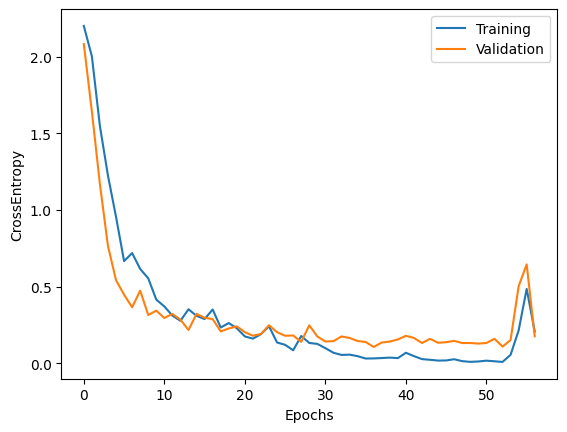

In [ ]:
model = ImageClassificationNet(10).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = train(model, train_loader, val_loader, optimizer, loss_fn, n_epochs=100, patience=20)

plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropy')
plt.legend()
plt.show()

In [ ]:
model.eval()
accuracy = []
input_prediction_label_triplets = []
for x, y in test_loader:
    with torch.no_grad():
      y_hat = model(x)
    prediction = torch.argmax(y_hat, dim=1)
    input_prediction_label_triplets.append((x.cpu(), prediction.cpu(), y.cpu()))
    accuracy.append((prediction == y).to(torch.float32))

accuracy = torch.cat(accuracy).mean()
print('Accuracy: ', accuracy.item())

Accuracy:  0.8881987929344177


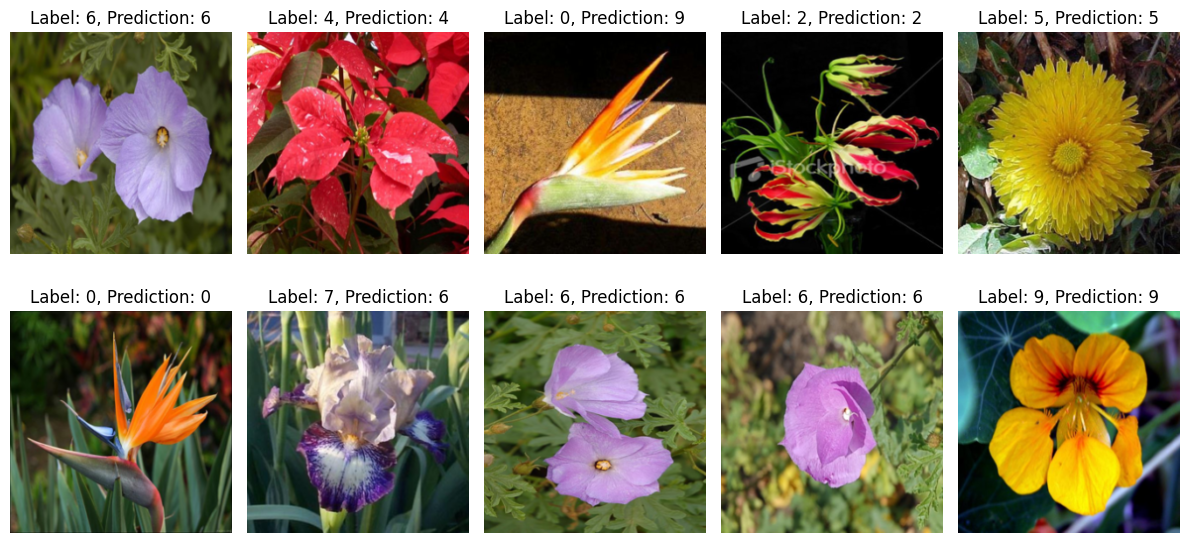

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(10):
    img, pred, y = input_prediction_label_triplets[0]
    img = img[i]
    pred = pred[i]
    y = y[i]
    plt.subplot(2, 5, i + 1)
    img = img.permute(1,2,0) * torch.tensor(mobilnet_std) + torch.tensor(mobilnet_mean)
    plt.imshow(img)
    plt.title(f"Label: {y}, Prediction: {pred}")
    plt.axis('off')

plt.tight_layout()
plt.show()